In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from category_encoders import LeaveOneOutEncoder

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

import optuna
from optuna.samplers import TPESampler

import warnings

warnings.filterwarnings('ignore')

C:\Users\user\anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv('../../../../../data/pg_epi4/train.csv').drop('id',axis=1)
test = pd.read_csv('../../../../../data/pg_epi4/test.csv')
origin = pd.read_csv('../../../../../data/pg_epi4/creditcard.csv')

In [3]:
train = pd.concat([train,origin],axis=0).drop_duplicates()

In [4]:
train.Class.value_counts()

0    501884
1       942
Name: Class, dtype: int64

In [5]:
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

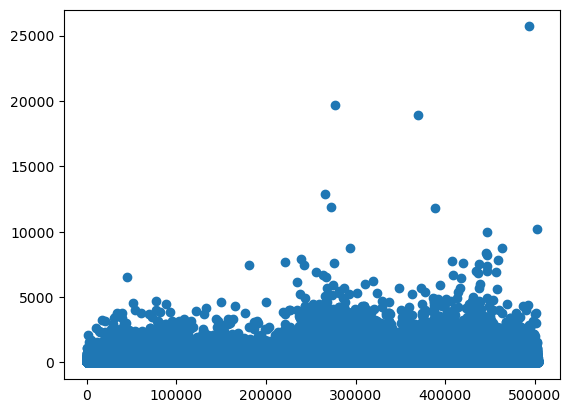

In [7]:
plt.scatter(range(len(train.Amount)),train.Amount)

In [8]:
train['hour'] = train['Time'] % (24 * 3600) // 3600
train['day'] = (train['Time'] // (24 * 3600))
# part0 = train[(train['day'] == 0)]
# part1 = train[(train['day'] == 1) & (train['hour'] < 9)]
# train = pd.concat([part0,part1],axis=0)

train = train.reset_index(drop=True)
test['hour'] = test['Time'] % (24 * 3600) // 3600
test['day'] = (test['Time'] // (24 * 3600))

In [9]:
scaler.fit(train)
col = train.columns
Class = train['Class']
train = scaler.transform(train)
train = pd.DataFrame(train,columns=col)
train['Class'] = Class
train = train.drop('day',axis=1)

In [10]:
# danger = []
# for j in range(2):
#     for i in range(24):
#         if j == 1 and i == 9:
#             break
#         tar = train[(train['hour'] == i) & (train['day'] == j)]
#         tp = tar.Class.value_counts()
#         danger.append(tp[1]/len(tar)*100)

In [11]:
# danger

In [12]:
# insert = []
# for i in range(len(train)):
#     for j in range(8,24):
#         if train.loc[i,'hour'] == j:
#             insert.append(danger[j-8])

# train['danger'] = insert

# insert = []
# for i in range(len(test)):
#     for j in range(24):
#         if test.loc[i,'hour'] == j:
#             insert.append(danger[j-9])
            
# test['danger'] = insert

In [13]:
# from sklearn.preprocessing import MinMaxScaler
# MM = MinMaxScaler()
# MM.fit(np.array(train.Amount).reshape(-1,1))
# tp = MM.transform(np.array(train.Amount).reshape(-1,1))
# train['Amount'] = tp

In [14]:
target = 'Class'
features = [c for c in train.columns if c not in ['id','Time','day', target]]

In [15]:
# drop V15,V23,V20,V5,V28,time

In [16]:
# target = 'Class'
# # features = ['V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10',
# #        'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19',
# #        'V21', 'V22', 'V24', 'V25', 'V26', 'V27', 'Amount']

# features = [ 'V1', 'V2', 'V3', 'V4', 'V7', 'V8', 'V9', 'V10',
#        'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19',
#        'V21', 'V24', 'V25', 'V26', 'Amount']

---

In [17]:
def cat_objective(trial):
    
    params_optuna = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }
    n=10
    cv = StratifiedKFold(n,shuffle=True, random_state=42)
    all_scores = []
    for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
        X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
        X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target]

        model = CatBoostClassifier(**params_optuna)
        model.fit(X_train,
                  y_train,
                  eval_set = [(X_val,y_val)],
                  early_stopping_rounds=50,
                  verbose=500)

        y_pred = model.predict_proba(X_val)[:,1]
        score = roc_auc_score(y_val,y_pred)
        all_scores.append(score)

    return np.mean(all_scores)

In [18]:
# study = optuna.create_study(direction='maximize', sampler = TPESampler())
# study.optimize(func=cat_objective, n_trials=50)
# study.best_params

In [19]:
# {'iterations': 15728,
#  'od_wait': 2182,
#  'learning_rate': 0.03336852544307129,
#  'reg_lambda': 2.3132945175291226,
#  'subsample': 0.01621008882000844,
#  'random_strength': 25.292157882359646,
#  'depth': 10,
#  'min_data_in_leaf': 10,
#  'leaf_estimation_iterations': 6,
#  'bagging_temperature': 0.01080117689593031,
#  'colsample_bylevel': 0.7579360851684404}
# study.best_params

NameError: name 'study' is not defined

In [20]:
kf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
models = []
val_scores = []

include_orig = True
'''
n_estimators=15000,
max_depth=5,
early_stopping_rounds = 200,
learning_rate=0.005,
one_hot_max_size = 3,
bootstrap_type = "MVS",
l2_leaf_reg = 2,
random_state = 1
'''
parms = {'iterations': 15728,
 'od_wait': 2182,
 'learning_rate': 0.03336852544307129,
 'reg_lambda': 2.3132945175291226,
 'subsample': 0.01621008882000844,
 'random_strength': 25.292157882359646,
 'depth': 10,
 'min_data_in_leaf': 10,
 'leaf_estimation_iterations': 6,
 'bagging_temperature': 0.01080117689593031,
 'colsample_bylevel': 0.7579360851684404}

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = CatBoostClassifier(**parms)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 2000)
    
    models.append(model)
    pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, pred)
    val_scores.append(score)
    
    print(f'AUC on fold {i}: {score:.4f}')
    
print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

0it [00:00, ?it/s]

0:	learn: 0.5930334	test: 0.5931115	best: 0.5931115 (0)	total: 209ms	remaining: 54m 45s
2000:	learn: 0.0012731	test: 0.0090190	best: 0.0079355 (350)	total: 1m 28s	remaining: 10m 5s


1it [01:52, 112.64s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.007935475247
bestIteration = 350

Shrink model to first 351 iterations.
AUC on fold 0: 0.9110
0:	learn: 0.5930620	test: 0.5932075	best: 0.5932075 (0)	total: 48.8ms	remaining: 12m 48s
2000:	learn: 0.0012142	test: 0.0086242	best: 0.0075740 (330)	total: 1m 27s	remaining: 10m 1s


2it [03:43, 111.64s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.007574036606
bestIteration = 330

Shrink model to first 331 iterations.
AUC on fold 1: 0.9127
0:	learn: 0.5930255	test: 0.5931694	best: 0.5931694 (0)	total: 45ms	remaining: 11m 47s
2000:	learn: 0.0012199	test: 0.0077602	best: 0.0071333 (376)	total: 1m 26s	remaining: 9m 50s


3it [05:33, 111.08s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.007133257083
bestIteration = 376

Shrink model to first 377 iterations.
AUC on fold 2: 0.9204
0:	learn: 0.5930662	test: 0.5932024	best: 0.5932024 (0)	total: 44.6ms	remaining: 11m 41s
2000:	learn: 0.0012818	test: 0.0079968	best: 0.0074617 (272)	total: 1m 26s	remaining: 9m 52s


4it [07:21, 109.70s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.007461672623
bestIteration = 272

Shrink model to first 273 iterations.
AUC on fold 3: 0.9134
0:	learn: 0.5929590	test: 0.5930756	best: 0.5930756 (0)	total: 45ms	remaining: 11m 47s
2000:	learn: 0.0011826	test: 0.0094360	best: 0.0083170 (375)	total: 1m 27s	remaining: 9m 57s


5it [09:13, 110.52s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.008317014375
bestIteration = 375

Shrink model to first 376 iterations.
AUC on fold 4: 0.8892
0:	learn: 0.5931415	test: 0.5932293	best: 0.5932293 (0)	total: 45.8ms	remaining: 12m
2000:	learn: 0.0012999	test: 0.0083125	best: 0.0076591 (336)	total: 1m 27s	remaining: 10m 1s


6it [11:05, 110.92s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.0076591169
bestIteration = 336

Shrink model to first 337 iterations.
AUC on fold 5: 0.9076
0:	learn: 0.5929892	test: 0.5931702	best: 0.5931702 (0)	total: 51ms	remaining: 13m 21s
2000:	learn: 0.0012761	test: 0.0085803	best: 0.0077954 (305)	total: 1m 29s	remaining: 10m 16s


7it [12:57, 111.49s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.007795420313
bestIteration = 305

Shrink model to first 306 iterations.
AUC on fold 6: 0.8920
0:	learn: 0.5930614	test: 0.5932390	best: 0.5932390 (0)	total: 46ms	remaining: 12m 3s
2000:	learn: 0.0012246	test: 0.0100568	best: 0.0088071 (175)	total: 1m 29s	remaining: 10m 15s


8it [14:43, 109.65s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.008807080515
bestIteration = 175

Shrink model to first 176 iterations.
AUC on fold 7: 0.8876
0:	learn: 0.5931430	test: 0.5932339	best: 0.5932339 (0)	total: 44.9ms	remaining: 11m 46s
2000:	learn: 0.0012020	test: 0.0081399	best: 0.0074279 (220)	total: 1m 25s	remaining: 9m 47s


9it [16:27, 107.88s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.007427862434
bestIteration = 220

Shrink model to first 221 iterations.
AUC on fold 8: 0.8844
0:	learn: 0.5931089	test: 0.5932335	best: 0.5932335 (0)	total: 45.4ms	remaining: 11m 54s
2000:	learn: 0.0012600	test: 0.0084474	best: 0.0076813 (379)	total: 1m 28s	remaining: 10m 7s


10it [18:21, 110.15s/it]

Stopped by overfitting detector  (2182 iterations wait)

bestTest = 0.007681308788
bestIteration = 379

Shrink model to first 380 iterations.
AUC on fold 9: 0.9090
mean AUC across all folds: 0.9027


In [21]:
val_scores

[0.9109989770582094,
 0.9127296690849016,
 0.9204080914568463,
 0.9134085921175404,
 0.8892494746070564,
 0.9075723699940854,
 0.8920340371267862,
 0.8875947713194136,
 0.884442369032862,
 0.9089938851196099]

In [22]:
sum(val_scores)/10

0.902743223691731

In [23]:
def xgb_objective(trial):
    
    params = {'max_depth': trial.suggest_int('max_depth', 1, 8),
          'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1), 
          'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
          'gamma': trial.suggest_float('gamma', 0.01, 1.0),
          'subsample': trial.suggest_float('subsample', 0.01, 1.0),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
          'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
          'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
          'n_estimators': trial.suggest_int('n_estimators', 100, 2000)}
    

    cv = StratifiedKFold(5,shuffle=True, random_state=42)
    all_scores = []
    for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
        X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
        X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target]

        model = XGBClassifier(**params)
        model.fit(X_train,
                  y_train,
                  eval_set = [(X_val,y_val)],
                  early_stopping_rounds=50,
                  verbose=500)

        y_pred = model.predict_proba(X_val)[:,1]
        score = roc_auc_score(y_val,y_pred)
        all_scores.append(score)

    return np.mean(all_scores)

In [24]:
# study = optuna.create_study(direction='maximize', sampler = TPESampler())
# study.optimize(func=xgb_objective, n_trials=50)
# study.best_params

In [25]:
kf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
val_scores = []

include_orig = True

# xgb_params = {'n_estimators'     : 3000,
#               'min_child_weight' : 96,
#               'max_depth'        : 7,
#               'learning_rate'    : 0.15,
#               'subsample'        : 0.95,
#               'colsample_bytree' : 0.95,
#               'reg_lambda'       : 1.50,
#               'reg_alpha'        : 1.50,
#               'gamma'            : 1.50,
#               'max_bin'          : 512,
#               'random_state'     : 1,
#               'objective'        : 'binary:logistic',
#               'tree_method'      : 'hist',
#               'eval_metric'      : 'auc'
#              }
xgb_params = {'max_depth': 3,
 'learning_rate': 0.09457198987172621,
 'min_child_weight': 9,
 'gamma': 0.3126168664550514,
 'subsample': 0.5585879695479943,
 'colsample_bytree': 0.46793424854801835,
 'reg_alpha': 0.21235299325212031,
 'reg_lambda': 0.4236760707956293,
 'n_estimators': 606}

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = XGBClassifier(**xgb_params)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 1000)
    
    models.append(model)
    pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, pred)
    val_scores.append(score)
    
    print(f'AUC on fold {i}: {score:.4f}')
    
print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

0it [00:00, ?it/s]

[10:19:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60355
[605]	validation_0-logloss:0.00807


1it [00:55, 55.78s/it]

AUC on fold 0: 0.8892
[10:20:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60358
[605]	validation_0-logloss:0.00768


2it [01:50, 55.07s/it]

AUC on fold 1: 0.9023
[10:21:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60351
[605]	validation_0-logloss:0.00752


3it [02:45, 55.07s/it]

AUC on fold 2: 0.8951
[10:22:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60354
[605]	validation_0-logloss:0.00782


4it [03:40, 55.12s/it]

AUC on fold 3: 0.8935
[10:23:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60358
[605]	validation_0-logloss:0.00859


5it [04:36, 55.24s/it]

AUC on fold 4: 0.8694
[10:24:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60352
[605]	validation_0-logloss:0.00781


6it [05:35, 56.55s/it]

AUC on fold 5: 0.9013
[10:25:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60356
[605]	validation_0-logloss:0.00827


7it [06:30, 56.25s/it]

AUC on fold 6: 0.8772
[10:26:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60358
[605]	validation_0-logloss:0.00901


8it [07:30, 57.32s/it]

AUC on fold 7: 0.8719
[10:27:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60352
[605]	validation_0-logloss:0.00771


9it [08:27, 57.39s/it]

AUC on fold 8: 0.8805
[10:28:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.60357
[605]	validation_0-logloss:0.00773


10it [09:25, 56.56s/it]

AUC on fold 9: 0.8983
mean AUC across all folds: 0.8879


In [26]:
val_scores

[0.8892130300655015,
 0.9022984607545181,
 0.8951149760289085,
 0.893499804780483,
 0.869392033323126,
 0.9013190404080658,
 0.8772258859878347,
 0.8719010138899017,
 0.8805332375798911,
 0.8983468965201482]

In [27]:
sum(val_scores)/10

0.8878844379338379

In [28]:
# target = 'Class'
# # features = ['V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10',
# #        'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19',
# #        'V21', 'V22', 'V24', 'V25', 'V26', 'V27', 'Amount']

# features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
#        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
#        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [29]:
def lgb_objective(trial):
    
    params_optuna = {
        
        'scale_pos_weight':trial.suggest_int('scale_pos_weight', 1, 3),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-12, 2, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 5, 25.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 35, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.65, 0.85),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.65),
        'bagging_freq': trial.suggest_int('bagging_freq', 4, 9),
         'min_child_samples': trial.suggest_int('min_child_samples', 40, 90),
         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 90, 150),
        "max_depth": trial.suggest_int("max_depth", 6, 12),
        'num_iterations':10000,
        'learning_rate':0.1
    }
    n=10
    cv = StratifiedKFold(n,shuffle=True, random_state=42)
    all_scores = []
    for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
        X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
        X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target]

        model = LGBMClassifier(**params_optuna)
        model.fit(X_train,
                  y_train,
                  eval_set = [(X_val,y_val)],
                  early_stopping_rounds=50,
                  verbose=500)

        y_pred = model.predict_proba(X_val)[:,1]
        score = roc_auc_score(y_val,y_pred)
        all_scores.append(score)

    return np.mean(all_scores)

In [30]:
# study = optuna.create_study(direction='maximize', sampler = TPESampler())
# study.optimize(func=lgb_objective, n_trials=50)
# study.best_params

In [31]:
# study.best_params

In [32]:
from lightgbm import log_evaluation, early_stopping
kf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
val_scores = []
# models = []
include_orig = True

# params = {'scale_pos_weight': 2,
#  'lambda_l2': 14.705798704172345,
#  'num_leaves': 45,
#  'feature_fraction': 0.8402041342033796,
#  'bagging_fraction': 0.5053012488246705,
#  'bagging_freq': 8,
#  'min_child_samples': 90,
#  'min_data_in_leaf': 111,
#  'max_depth': 6}
params = {'scale_pos_weight': 1,
 'lambda_l1': 7.688167496328092e-12,
 'lambda_l2': 10.40459734442428,
 'num_leaves': 44,
 'feature_fraction': 0.6971821098041336,
 'bagging_fraction': 0.5486874601157361,
 'bagging_freq': 9,
 'min_child_samples': 65,
 'min_data_in_leaf': 116,
 'max_depth': 10}

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = LGBMClassifier(**params)

    callbacks = [log_evaluation(period=200), early_stopping(stopping_rounds=200)]
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], callbacks = callbacks)
    
    models.append(model)
    pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, pred)
    val_scores.append(score)
    
    print(f'AUC on fold {i}: {score:.4f}')
    
print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

0it [00:00, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


1it [00:01,  1.35s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.00809759
AUC on fold 0: 0.8976
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


2it [00:02,  1.33s/it]

Did not meet early stopping. Best iteration is:
[69]	valid_0's binary_logloss: 0.00776447
AUC on fold 1: 0.9122
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


3it [00:03,  1.31s/it]

Did not meet early stopping. Best iteration is:
[59]	valid_0's binary_logloss: 0.00745236
AUC on fold 2: 0.8925
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


4it [00:05,  1.31s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's binary_logloss: 0.00761621
AUC on fold 3: 0.9035
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


5it [00:06,  1.30s/it]

Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.00839645
AUC on fold 4: 0.8810
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


6it [00:07,  1.30s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.00770917
AUC on fold 5: 0.9044
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


7it [00:09,  1.31s/it]

Did not meet early stopping. Best iteration is:
[48]	valid_0's binary_logloss: 0.00799458
AUC on fold 6: 0.8821
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


8it [00:10,  1.30s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0089602
AUC on fold 7: 0.8849
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


9it [00:11,  1.30s/it]

Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.00757592
AUC on fold 8: 0.8829
[LightGBM] [Warning] feature_fraction is set=0.6971821098041336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971821098041336
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l1 is set=7.688167496328092e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.688167496328092e-12
[LightGBM] [Warning] bagging_fraction is set=0.5486874601157361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486874601157361
[LightGBM] [Warning] lambda_l2 is set=10.40459734442428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.40459734442428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 200 rounds


10it [00:13,  1.34s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's binary_logloss: 0.00774229
AUC on fold 9: 0.9148
mean AUC across all folds: 0.8956


In [33]:
val_scores

[0.8976229427233142,
 0.912165842901068,
 0.8925242371071394,
 0.9034954255891454,
 0.8810489401953916,
 0.9044374205618453,
 0.8820585661741638,
 0.8849129401111395,
 0.8828500582490686,
 0.9148168842598638]

In [34]:
sum(val_scores)/10

0.895593325787214

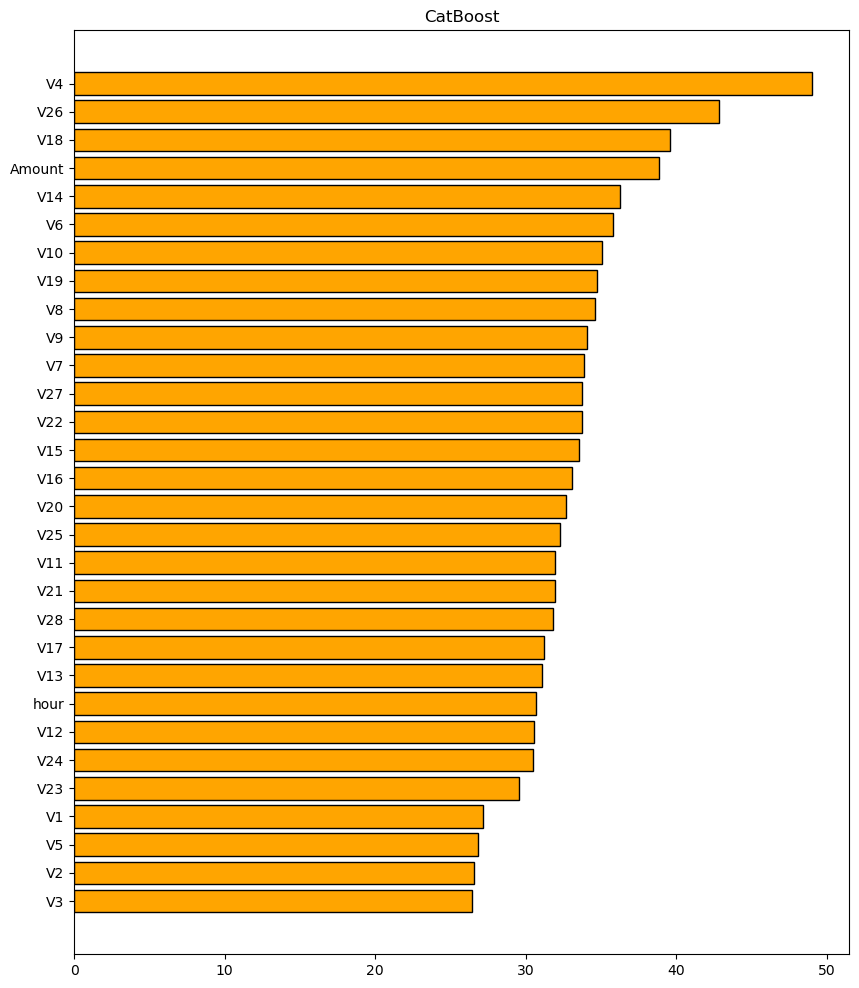

In [35]:
plt.figure(figsize = (10, 12))
cat_imp = np.zeros(len(models[0].feature_importances_))
for model in models[:10]:
    cat_imp += model.feature_importances_
    
plt.barh([features[i] for i in np.argsort(cat_imp)], sorted(cat_imp), 
         color = "orange", edgecolor = "#000000")

plt.title("CatBoost")
plt.show()

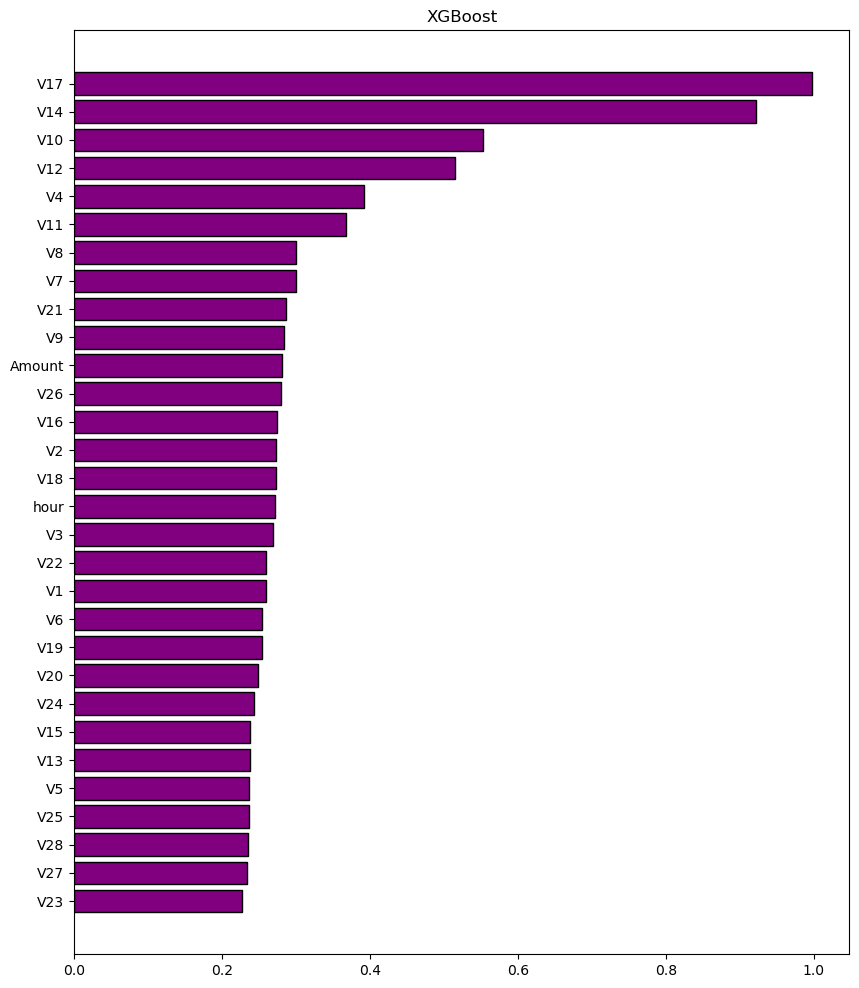

In [36]:
plt.figure(figsize = (10, 12))
xgb_imp = np.zeros(len(models[10].feature_importances_))
for model in models[10:20]:
    xgb_imp += model.feature_importances_
    
plt.barh([features[i] for i in np.argsort(xgb_imp)], sorted(xgb_imp), 
         color = "purple", edgecolor = "#000000")

plt.title("XGBoost")
plt.show()

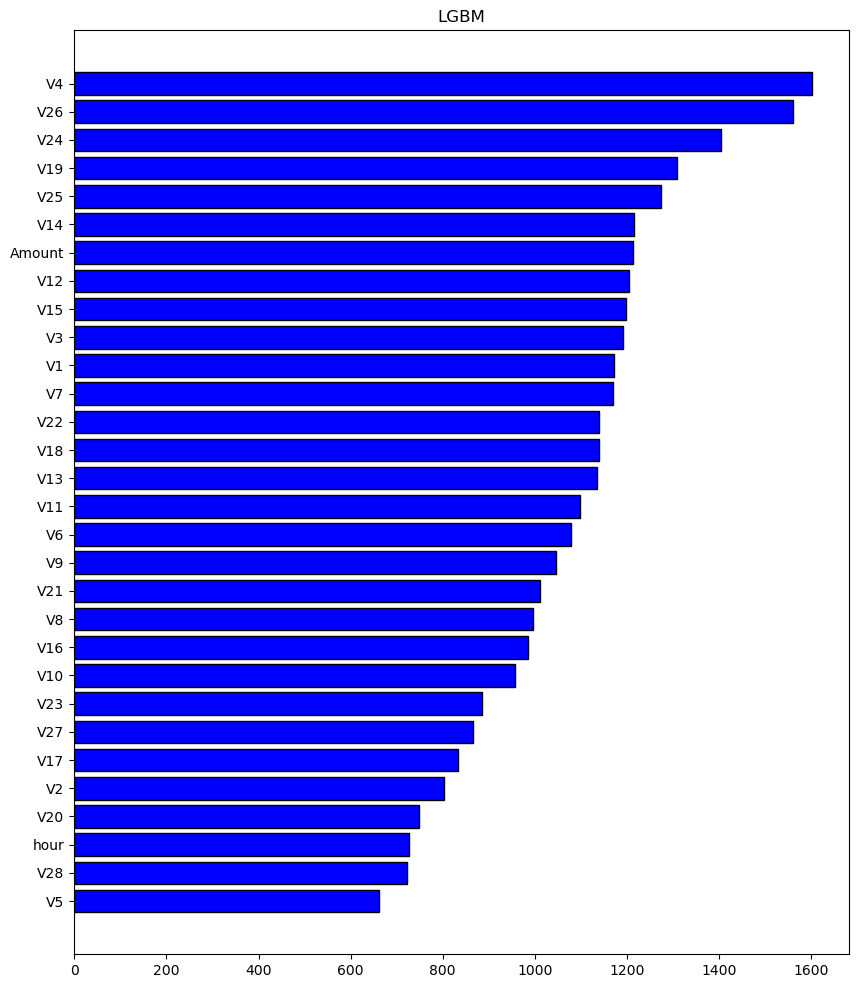

In [37]:
plt.figure(figsize = (10, 12))
lgbm_imp = np.zeros(len(features))
for model in models[20:]:
    lgbm_imp += model.feature_importances_
    
plt.barh([features[i] for i in np.argsort(lgbm_imp)], sorted(lgbm_imp), 
         color = "blue", edgecolor = "#000000")

plt.title("LGBM")
plt.show()

In [38]:
cat_preds = []
xgb_preds = []
lgbm_preds = []

for model in models[:10]:
    preds = model.predict_proba(test[features])[:,1]
    cat_preds.append(preds)
    
for model in models[10:20]:
    preds = model.predict_proba(test[features])[:,1]
    xgb_preds.append(preds)
    
for model in models[20:]:
    preds = model.predict_proba(test[features])[:,1]
    lgbm_preds.append(preds)

In [39]:
# lgbm_preds = []
# for model in models:
#     preds = model.predict_proba(test[features])[:,1]
#     lgbm_preds.append(preds)

In [40]:
cat_preds = np.stack(cat_preds).mean(0)
cat_preds # cv 10개 모델의 평균

array([0.0008358 , 0.0005414 , 0.00016388, ..., 0.0005703 , 0.00015689,
       0.00028077])

In [41]:
# cat_preds = np.stack(cat_preds).mean(0)
xgb_preds = np.stack(xgb_preds).mean(0)
lgbm_preds = np.stack(lgbm_preds).mean(0)

In [42]:
cat_df = pd.DataFrame(data = {'id': test.id, 'Class': cat_preds})
xgb_df = pd.DataFrame(data = {'id': test.id, 'Class': xgb_preds})
lgbm_df = pd.DataFrame(data = {'id': test.id, 'Class': lgbm_preds})

print("Cat Correlation with XGB:")
display(cat_df.Class.corr(xgb_df.Class))
print("Cat Correlation with LGBM:")
display(cat_df.Class.corr(lgbm_df.Class))
print("XGB Correlation with LGBM:")
display(xgb_df.Class.corr(lgbm_df.Class))

Cat Correlation with XGB:


0.9430081206954292

Cat Correlation with LGBM:


0.968700750589783

XGB Correlation with LGBM:


0.9658825169785414

In [46]:
blended_preds = 0.5*cat_preds + 0.3*xgb_preds + 0.2*lgbm_preds
blended_preds

array([0.00173702, 0.00072687, 0.00020086, ..., 0.00069496, 0.00011915,
       0.00028117])

In [47]:
submission = pd.DataFrame(data = {'id': test.id, 'Class': blended_preds})

In [49]:
submission.to_csv('blended.csv', index=False)